In [1]:
%reload_ext Cython
%reload_ext line_profiler

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.constants import c, e, m_p
from scipy.signal import fftconvolve

%matplotlib nbagg
import seaborn as sns
sns.set_context('notebook', font_scale=1.5,
                rc={'lines.markeredgewidth': 1})
sns.set_style('darkgrid', {
        'axes.linewidth': 2,
        'legend.fancybox': True})

/usr/lib64/python2.7/site-packages/matplotlib/__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


## Bunch creation

We create a bunch - LHC type. No fancy wrapper function available yet to produce a RF matched distribution. A little tedious because it requires quite some definitions to be done beforehand of the full RF System - but that's due to the nature of the problem.

- Some beam kinetic parameters and RF machine parameters

In [3]:
from PyHEADTAIL.trackers.rf_bucket import RFBucket
from PyHEADTAIL.particles.generators import ParticleGenerator, \
    gaussian2D, RF_bucket_distribution, StationaryExponential

PyHEADTAIL v1.9.3.10




In [4]:
momentum = 450e9 * e/c
gamma = np.sqrt((momentum/(m_p*c))**2 + 1)
beta = np.sqrt(1 - gamma**-2)

circumference = 26658.883
alpha = 3.225e-4
h1 = 35640
V1 = 8e6
p_increment = 0 * e/c * circumference/(beta*c)

print gamma

479.606062093


In [5]:
rfbucket = RFBucket(
    charge=e, mass=m_p, gamma=gamma,
    circumference=circumference,
    alpha_array=[alpha], p_increment=0,
    harmonic_list=[h1], voltage_list=[V1], phi_offset_list=[0])

In [6]:
dt = (0, 2.5e-9, 7.5e-9)
epsn_z = (0.35, 0.25, 0.1)

In [7]:
bunches = [
    ParticleGenerator(
        macroparticlenumber=1e5, intensity=1e11,
        charge=e, mass=m_p, gamma=gamma,
        circumference=26658.883,
        distribution_x=gaussian2D(2e-6),
        distribution_y=gaussian2D(2e-6),
        distribution_z=RF_bucket_distribution(rfbucket, epsn_z=epsn_z[i])
    ).generate() for i in xrange(3)]

*** Maximum RMS emittance 0.888689919173eV s.
... distance to target emittance: 2.32e-02
... distance to target emittance: 2.34e-02
... distance to target emittance: -5.11e-04
... distance to target emittance: 1.04e-05
--> Emittance: 0.350000004218
--> Bunch length:0.0697492609648

/home/kli/workspace/PyHEADTAIL/particles/generators.py:330: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  coords = [np.random.normal(loc=0., scale=std, size=n_particles),
/home/kli/workspace/PyHEADTAIL/particles/generators.py:331: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  np.random.normal(loc=0., scale=std, size=n_particles)]
/home/kli/workspace/PyHEADTAIL/particles/generators.py:530: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  u = uniform(low=xmin, high=xmax, size=n_gen)



*** Maximum RMS emittance 0.888689919173eV s.
... distance to target emittance: 1.69e-02
... distance to target emittance: 1.70e-02
... distance to target emittance: -4.02e-05
--> Emittance: 0.250000069118
--> Bunch length:0.0580813886211
*** Maximum RMS emittance 0.888689919173eV s.
... distance to target emittance: 2.45e-03
... distance to target emittance: 2.57e-03
... distance to target emittance: 1.73e-06
--> Emittance: 0.100000001214
--> Bunch length:0.0359672667212


/home/kli/workspace/PyHEADTAIL/particles/generators.py:531: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  v = uniform(low=ymin, high=ymax, size=n_gen)
/home/kli/workspace/PyHEADTAIL/particles/generators.py:532: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  s = uniform(size=n_gen)


In [8]:
for i, b in enumerate(bunches):
    b.z -= dt[i] * (b.beta*c)
    b.dt = dt[i]

bunch1, bunch2, bunch3 = bunches
allbunches = sum(bunches)
allbunches.dt = dt[0]

In [31]:
# plt.plot(allbunches.z, allbunches.dp, '.')
# plt.xlabel("z [m]")
# plt.ylabel(r"$\delta$")
# plt.show()

## Wakes, slicing, convolution etc.

The CircularResonator wake is a special resonator wake with Yokoya factors X1=1, Y1=1, X2=0, Y2=0

functions transverse and longitudinal are actually meant to be used internally when building the wake kicks - at this point they are concatenated with the respective Yokoya factor being applied/provided. For visualisation we can also build them externally manually.

In [9]:
from PyHEADTAIL.impedances.wakes import CircularResonator, WakeField
from PyHEADTAIL.particles.slicing import UniformBinSlicer

In [10]:
wake = CircularResonator(R_shunt=1e9, frequency=1e9, Q=20)
slicer = UniformBinSlicer(60, z_cuts=(-.3, .3))

wakefields = WakeField(slicer, wake)
kick = wakefields.wake_kicks[0]
wf = kick.wake_function

slices = []
times, cmoments = [], []
for i, b in enumerate(bunches):
    distance = dt[i]*b.beta*c
    b.z += distance
    slices.append(b.get_slices(slicer))
    times.append(slices[-1].z_centers / (b.beta*c))
    cmoments.append(slices[-1].charge_per_slice)
    b.z -= distance

slices1, slices2, slices3 = slices
times1, times2, times3 = times
cmoments1, cmoments2, cmoments3 = cmoments

# Make multi-turn multi-bunch arrays
n_turns = 1
n_bunches = len(bunches)
n_slices = len(times[0])

tmp = np.zeros((n_turns, n_bunches, n_slices))
tmp[0,:,:] = times
times = tmp

tmp = np.zeros((n_turns, n_bunches, n_slices))
tmp[0,:,:] = cmoments
cmoments = tmp
    
ages = np.array([0 for b in bunches])
betas = np.array([[b.beta for b in bunches]])

*** PyHEADTAIL WARNING! Acceleration not handled properly by this kind of convolution due to changing bunch length!
*** PyHEADTAIL WARNING! Acceleration not handled properly by this kind of convolution due to changing bunch length!


## Convolutions

In [11]:
def convolution_python(t_target, t_source, c_source, w):
    dxp = 0.*t_target
    for k in xrange(len(t_target)):
        for l in xrange(len(t_source)):
            dxp[k] += c_source[l]*w(t_target[k]-t_source[l])

    return dxp

In [12]:
def convolution_numpy(t_target, t_source, c_source, w):
    tmin, tmax = t_source[0], t_source[-1]
    tt = np.concatenate((t_target-tmax, (t_target-tmin)[1:]))
    
    return np.convolve(c_source, w(tt), mode='valid')

In [13]:
def convolve_multibunch(times, moments, wf, dt=None, f_convolution=convolution_python):
    dxp = []
    if dt is None: dt = 0.*np.array(times)
    for i in xrange(len(times)):
        z = 0.*times[i]
        t_target = times[i]
        for j in range(i+1):
            t_source = times[j] + dt[i] - dt[j]
            c_source = moments[j]
            z += f_convolution(t_target, t_source, c_source, wf)
            
        dxp.append(z)
        
    return dxp

In [14]:
f_kick = wakefields.wake_kicks[0]

delta_xp = f_kick._accumulate_source_signal_multibunch(bunches, times, ages, cmoments, betas)

In [15]:
%timeit f_kick._accumulate_source_signal_multibunch(bunches, times, ages, cmoments, betas)

The slowest run took 4.99 times longer than the fastest. This could mean that an intermediate result is being cached.
10000 loops, best of 3: 180 µs per loop


In [16]:
times = np.squeeze(times)
cmoments = np.squeeze(cmoments)
delta_xp_np = convolve_multibunch(times, cmoments, wf, dt)

In [17]:
%timeit convolve_multibunch(times, cmoments, wf, dt)
%timeit convolve_multibunch(times, cmoments, wf, dt, f_convolution=convolution_numpy)

10 loops, best of 3: 83.9 ms per loop
10000 loops, best of 3: 144 µs per loop


<IPython.core.display.Javascript object>


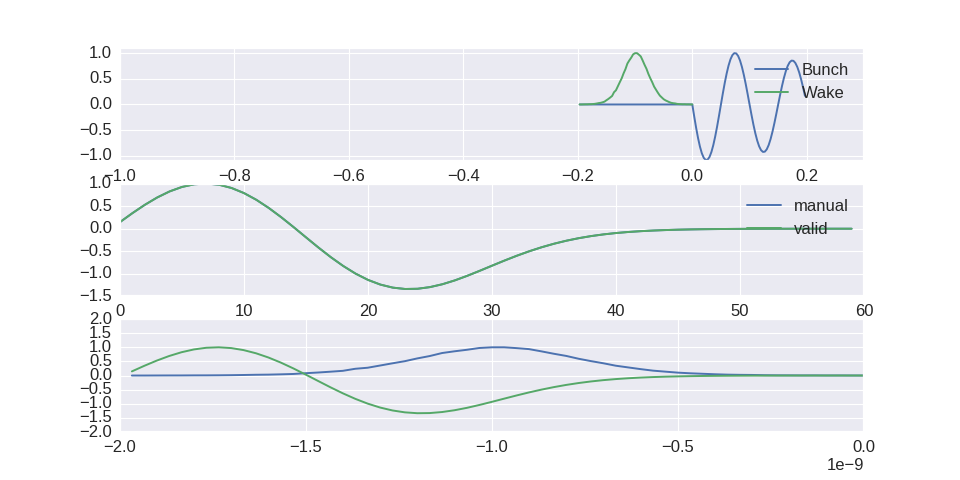

<IPython.core.display.Javascript object>


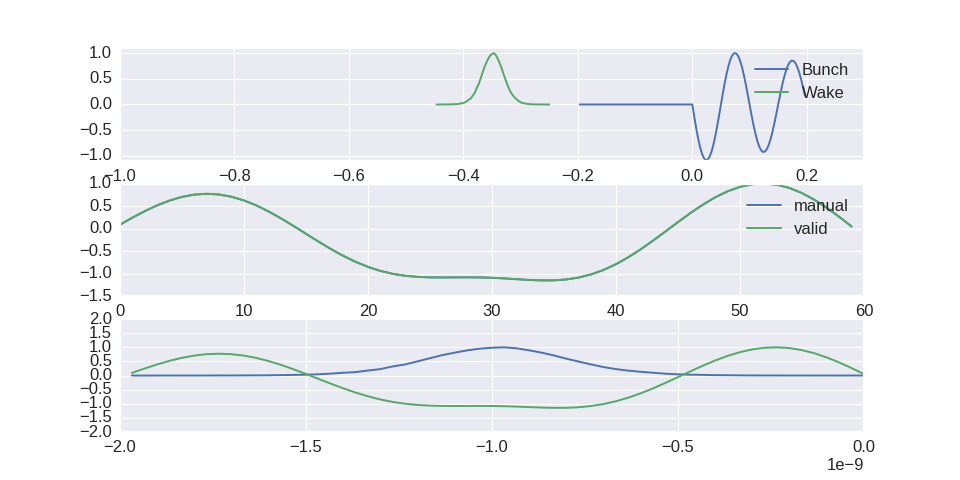

<IPython.core.display.Javascript object>


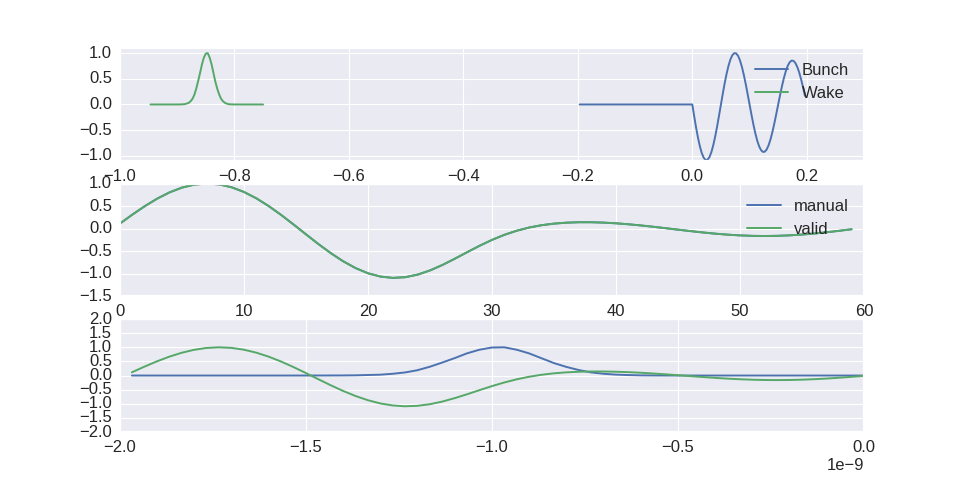

In [18]:
for i, s in enumerate(slices):
    dts = times[i]
    t0 = np.concatenate((dts-dts[-1], (dts-dts[0])[1:]))

    fig, (ax1, ax2, ax3) = plt.subplots(3, figsize=(12,6))

    ax1.plot(t0, wf(t0)[::-1]/max(wf(t0)[::-1]))
    ax1.plot(dts-dts[-1]-dt[i], s.charge_per_slice/max(s.charge_per_slice))
    ax1.set_ylim((-1.1, 1.1))
    ax1.legend(['Bunch', 'Wake'])
    ax1.set_xlim(-10e-9, 3e-9)
    ax2.plot(-delta_xp[i]/max(-delta_xp[i]))
    ax2.plot(delta_xp_np[i]/max(delta_xp_np[i]))
    ax2.legend(['manual', 'valid'])
    ax3.plot(dts-dts[-1], s.charge_per_slice/max(s.charge_per_slice))
    ax3.plot(dts-dts[-1], delta_xp_np[i]/max(delta_xp_np[i]))
    ax3.set_ylim(-2, 2)

plt.show()

### All bunches

In [19]:
allslicer = UniformBinSlicer(400, z_cuts=(-3, .5))
allslices = allbunches.get_slices(allslicer)

alltimes = allslices.z_centers / (allbunches.beta*c)
allcmoments = allslices.charge_per_slice

# Make multi-turn multi-bunch arrays
n_turns = 1
n_bunches = 1
n_slices = len(alltimes)

tmp = np.zeros((n_turns, n_bunches, n_slices))
tmp[0,:,:] = alltimes
alltimes = tmp

tmp = np.zeros((n_turns, n_bunches, n_slices))
tmp[0,:,:] = allcmoments
allcmoments = tmp
    
ages = np.array([0])
betas = np.array([[allbunches.beta]])

In [20]:
alldelta_xp = f_kick._accumulate_source_signal_multibunch(allbunches, alltimes, ages, allcmoments, betas)[0]

alltimes = np.squeeze(alltimes)
allcmoments = np.squeeze(allcmoments)
alldelta_xp_np = convolve_multibunch([np.squeeze(alltimes)], [np.squeeze(allcmoments)], wf)[0]

<IPython.core.display.Javascript object>


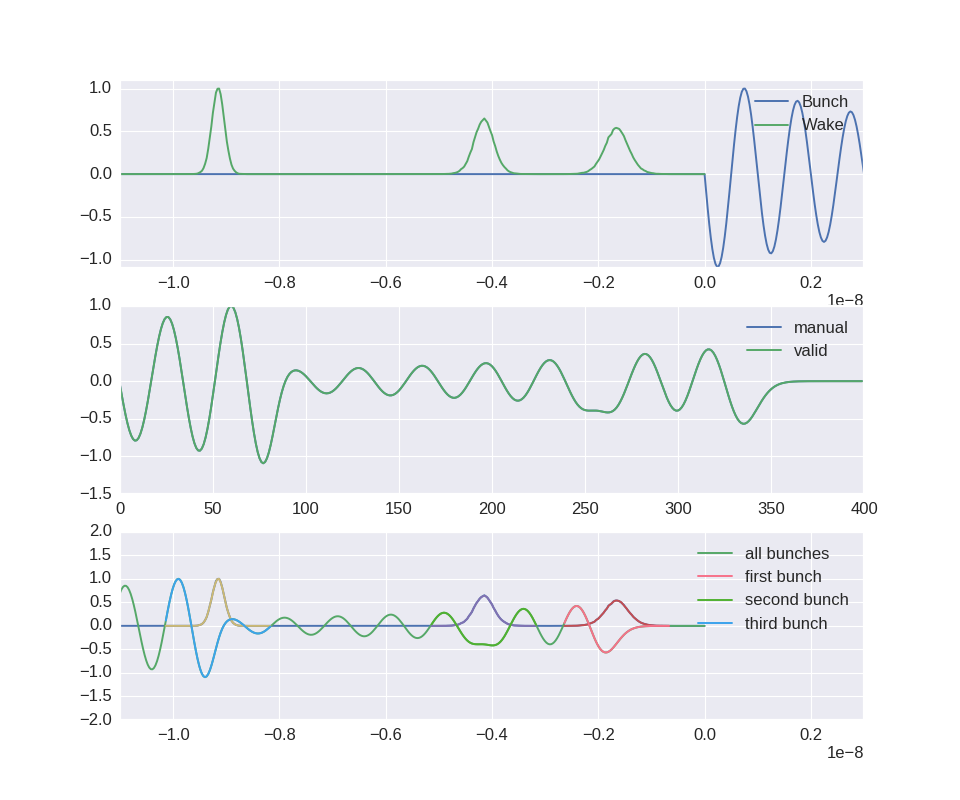

In [21]:
t0 = np.concatenate((alltimes-alltimes[-1],
                    (alltimes-alltimes[0])[1:]))
scale_kick = 1./max(alldelta_xp_np)
scale_charge = 1./max(allcmoments)
scale_charge2 = 1./max([max(s.charge_per_slice) for s in slices])

col = sns.color_palette('husl', 6)
fig, (ax1, ax2, ax3) = plt.subplots(3, figsize=(12,10))

ax1.plot(t0, wf(t0)[::-1]/max(wf(t0)[::-1]))
ax1.plot(alltimes-alltimes[-1], allcmoments/max(allcmoments))
ax1.set_ylim((-1.1, 1.1))
ax1.legend(['Bunch', 'Wake'])
ax1.set_xlim(-11e-9, 3e-9)

ax2.plot(-alldelta_xp/max(-alldelta_xp))
ax2.plot(alldelta_xp_np/max(alldelta_xp_np))
ax2.legend(['manual', 'valid'])

ax3.plot(alltimes-alltimes[-1], allcmoments*scale_charge)
ax3.plot(alltimes-alltimes[-1], alldelta_xp_np/max(alldelta_xp_np), label="all bunches")

labels = ["first bunch", "second bunch", "third bunch"]
for i, s in enumerate(slices):
    dts = times[i]
    dxp = delta_xp[i]
    ax3.plot(dts-alltimes[-1]-dt[i], s.charge_per_slice*scale_charge2)
    if i==2:
        ax3.plot(dts-alltimes[-1]-dt[i], -dxp/max(-delta_xp[-1]), label=labels[i], c=col[i*2])
    else:
        ax3.plot(dts-alltimes[-1]-dt[i], -dxp/max(-delta_xp[-1]), label=labels[i], c=col[i*2])

#     [ax3.axvline(s, c=c[0], alpha=0.8) for s in (dts-dts[-1])]
#     [ax3.axvline(s, c=c[1], alpha=0.8) for s in (dts-dts[-1]-dt[i])]
#     [ax3.axvline(s, c=c[2], alpha=0.8) for s in (alltimes-alltimes[-1])]

ax3.legend()
ax3.set_xlim(-11e-9, 3e-9)
ax3.set_ylim(-2, 2)

plt.show()

In [21]:
plt.close('all')